In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0: Check Variables

In [ ]:
filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(2007) + '.parquet'
df = pd.read_parquet(filename, engine = 'pyarrow')
df.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng',
       'county_name', 'district', 'precinct', 'region', 'subject_race',
       'subject_sex', 'officer_id_hash', 'type', 'violation',
       'citation_issued', 'warning_issued', 'outcome', 'contraband_found',
       'contraband_drugs', 'contraband_weapons', 'search_conducted',
       'search_vehicle', 'search_basis', 'vehicle_color', 'vehicle_make',
       'vehicle_model', 'vehicle_type', 'vehicle_year', 'raw_HA_RACE_SEX',
       'raw_HA_SEARCH_PC_boolean', 'raw_HA_SEARCH_CONCENT_boolean',
       'raw_HA_INCIDTO_ARREST_boolean', 'raw_HA_VEHICLE_INVENT_boolean',
       'year'],
      dtype='object')

In [ ]:
df.iloc[:10,:]['search_vehicle']

2693894    False
2693895    False
2693896    False
2693897    False
2693898    False
2693899    False
2693900    False
2693901    False
2693902    False
2693903    False
Name: search_vehicle, dtype: object

In [ ]:
df.iloc[:10,:]['search_basis']

2693894    NaN
2693895    NaN
2693896    NaN
2693897    NaN
2693898    NaN
2693899    NaN
2693900    NaN
2693901    NaN
2693902    NaN
2693903    NaN
Name: search_basis, dtype: category
Categories (5, object): ['k9', 'plain view', 'consent', 'probable cause', 'other']

##### Preprocessing functions

In [ ]:
def remove_duplicates(row):
  if row['speeding_only'] == 'speeding-repeated_entries':
    return row['all_violation'][0].strip()
  else:
    return row['violation']

def remove_white_spaces(vio_lst):
  vio_lst = [x.strip() for x in vio_lst]
  return vio_lst


def exclusive(vio_lst):
  count = 0
  for vio in vio_lst:
    # count number of violations containing 'speed'
    if 'speed' in vio:
      count += 1
  # if we have non-speeding violation
  if count < len(vio_lst):
    return 'speeding + others'
  # if we only have speeding violation
  elif count == len(vio_lst):
    # if one speeding vio type
    if count == 1:
      return 'speeding-1'
    # if we have more than one entries but only one type
    elif len(set(vio_lst)) == 1:
      return 'speeding-repeated_entries'
    # if we have more than one type
    else:
      return 'speeding-multiple'
  else:
    return 'undefined case'

In [ ]:
def speeding_filter(df):
  print('Before speed filtering: ', len(df))
  df['violation'] = [s.lower() for s in df['violation']]
  # at least one violation is speeding-violated (could have other violations at the same time)
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['all_violation'] = df['all_violation'].map(lambda x: remove_white_spaces(x))
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1','speeding-multiple']),:]

  df['violation'] = df.apply(lambda row: remove_duplicates(row), axis = 1)

  df.drop(['all_violation','speeding_only'], axis = 1, inplace = True)
  print('Speeding only violation has records: ', len(df))
  return df

In [ ]:
# this function is called by preprocess
def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)

In [ ]:
# columns we need in the analysis
keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'citation_issued',
            ]

# delete rows with missing value in these columns
rm_na_col = ['county_name','violation','subject_race','subject_sex']

In [ ]:
### this function used in run_year_analysis()
def preprocess(year, rm_na_col, analysis_type,
               violation_types=None, border_counties=None, county_type=None, speeding_only=False):
  """
  with_vio: if include vioation type variables: True, if not include, False
  violation_types: violation types to be included in the analysis
  """
  # read dataframe
  # CHANGED 2023/07/12, why file_path: '/content/drive/MyDrive/traffic_stop/year_data_daylight/'???
  filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  if violation_types:
    filename = '/content/drive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print('# of all traffic stops in year ', year, ': ', len(df))

  # invalid value (IF NOT TEXAS STATE DATA, DELETE THIS INVALID VALUE BLOCK)
  if year == 2013:
    df.drop(df.index[df['lat'] == 74.052879], inplace=True)

  # based on analysis types, decide which columns to keep
  if analysis_type == 'citation':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'citation_issued',
            ]
  elif analysis_type == 'search':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'search_conducted'
            ]
  elif analysis_type == 'contraband':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'search_conducted',
            'contraband_found',
            ]

  # drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)
    # newly added 2023/07/12
    print('# of traffic stops after preprocessing step 0 - drop na/unknown in COL [',col,']: ',len(df))

  # if we want to only include certain violation types:
  if violation_types:
    print('Including only serious violations')
    #df['violation'] = df['violation'].map(lambda x: x.replace(' (#)', '').strip())
    df = df.loc[df['violation'].isin(violation_types),:]
    print(len(df))

  # filter rows if speeding_only
  if speeding_only:
    # filter: only speeding violation (no other violations)
    df = speeding_filter(df)

  ######### THIS WHOLE BLOACK NEEDS TO BE CHANGED, NEW METROPOLITAN FILES AND DIFFERENT DATA FORMAT #########

  # County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/content/drive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county'] = [name[:-7] for name in df['county_name']]
  df['county'] = df['county'].replace('Dewitt','DeWitt')

  # if we want to include only border counties:
  if border_counties:
    print('Including only border counties')
    df = df.loc[df['county'].isin(border_counties),:]

  df = df.join(county_df.set_index('County Name'), on='county')
  df.drop('county', axis = 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  if county_type:
    print('Including only a certain type of county')
    df = df.loc[df['county_type'] == county_type,:]
    df.drop(['county_type'], axis = 1, inplace = True)

  # newly added 2023/07/12
  print('# of traffic stops after preprocessing step 1(add county type): ', len(df))
  ###############################################################

  # COMMENT 2023/07/12: What is this????
  #county_df2 = pd.read_csv('/content/drive/MyDrive/traffic_stop/countyinfo.csv')
  #county_df2 = county_df2[county_df2['State']=='Texas']
  #county_df2 = county_df2.filter(items=['Region', 'County Name'])

  # transform column
  #df['county'] = [name[:-7] for name in df['county_name']]
  #df['county'] = df['county'].replace('Dewitt','DeWitt')
  #df = df.join(county_df2.set_index('County Name'), on='county')
  #df.drop('county', axis = 1, inplace=True)
  #df.rename(columns={'Region':'county_region'}, inplace=True)

  # newly added 2023/07/12
  #print('# of traffic stops after preprocessing step 1(add county region): ', len(df))

  ######### Metropolitan block ends here #########

  # if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()

  df.drop(['county_name','violation'], axis = 1, inplace = True)

  # I delete the block for with_vio, we never used that

  # based on analysis type, decide y
  if analysis_type == 'citation':
    # Convert 'citation issued' to integer
    df = df.astype({'citation_issued': 'int64'})
    y = df['citation_issued']
    df.drop(['citation_issued'], axis = 1, inplace = True)

  elif analysis_type == 'search':
    df["search_conducted"].fillna(False, inplace = True)
    df = df.astype({'search_conducted': 'int64'})
    y = df['search_conducted']
    df.drop(['search_conducted'], axis = 1, inplace = True)

  elif analysis_type == 'contraband':
    df= df[(df['search_conducted']==1)]
    df = df.reset_index(drop = True)
    df = df.astype({'contraband_found': 'int64'})
    y = df['contraband_found']
    df.drop(['contraband_found', 'search_conducted'], axis = 1, inplace = True)


  # other x variables get dummies
  df = pd.get_dummies(df)
  if not county_type:
    df.drop(['subject_race_white', 'county_type_Metropolitan', 'subject_sex_male'], axis = 1, inplace = True)
  else:
    df.drop(['subject_race_white', 'subject_sex_male'], axis = 1, inplace = True)

  df.reset_index(drop=True, inplace=True)
  y.reset_index(drop=True, inplace=True)

  print('# of traffic stops after preprocessing in year ', year, ': ', len(df))
  return (y, df)

In [ ]:
### this function used in generate_outputs()
def run_year_analysis(analysis_type, rm_na_col, df_years,
                      violation_types=None, border_counties=None, county_type=None, speeding_only=False):
  """
  param:
  violation_types: violation types to be included in the analysis

  Output:
  A result dataframe
  """
  years = list(range(year_start, year_end+1))

  for year in years:
    # read in the data
    print('***********************************')
    print(year)

    # read in and preprocess data
    y, X = preprocess(year, rm_na_col, analysis_type, violation_types, border_counties, county_type, speeding_only)
    # added 2023/07/12
    print(X.columns)

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()

    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values),
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})

    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)),
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)),
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file

In [ ]:
sns.set_theme()
sns.set_style("whitegrid")

In [ ]:
def generate_outputs(folder_path, analysis_type, violation_types = None, border_counties=None, county_type=None, speeding_only = False):
  """
  function outputs a csv file, a jpg and an svg figure
  PARAMS:
  folder path: eg., '/gdrive/MyDrive/traffic_stop/output_0502/'
  """
  # columns to store
  var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander','subject_sex_female']

  df_years = pd.DataFrame({'variable':var_lst_baseline})


  res_df = run_year_analysis(analysis_type=analysis_type, rm_na_col=rm_na_col, df_years=df_years, violation_types=violation_types,
                    border_counties=border_counties, county_type=county_type, speeding_only=speeding_only)

  # save csv
  speeding = '_speeding' if speeding_only else ''
  violation = '_SeriousVio' if violation_types else ''
  border = '_non_border' if border_counties else ''
  county = '_' + county_type if county_type else ''

  file_name = analysis_type + speeding + violation + border + county + '.csv'

  # CHANGE THE PATH
  save_path = folder_path + file_name
  res_df.to_csv(save_path, index = False)

  years = list(range(year_start, year_end + 1))

  #sns.set_theme()
  #sns.set_style("white")
  sns.set(font_scale=1.25)
  plt.style.use('seaborn-whitegrid')

  sns.lineplot(x = years, y = black, color = 'red', label="Black")
  sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
  sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

  sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

  sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')


  plt.axhline(y=1, color='grey', alpha=0.8, linestyle='-')
  plt.xlabel('Year')
  plt.ylabel('Odds Ratio')
  plt.legend(bbox_to_anchor=(0.5, -0.36), loc='lower center', ncol = 3)



  # CHANGE THE PATH HERE
  #figure_name1 = file_name.replace('csv', 'svg')
  figure_name2 = file_name.replace('csv', 'jpg')
  #figure_name3 = file_name.replace('csv', 'pdf')
  #plt.savefig((folder_path+figure_name1), format = 'svg', bbox_inches="tight")
  plt.savefig((folder_path+figure_name2), dpi = 200, bbox_inches="tight")
  #plt.savefig((folder_path+figure_name3), format="pdf", bbox_inches="tight")

  plt.show()


### 00 : Test the refactored code works

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
# of traffic stops after preprocessing step 1(add county type):  2673511
# of traffic stops after preprocessing in year  2006 :  2671708
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.683415
         Iterations 4
***********************************
2007
# of all traffic stops in year  2007 :  

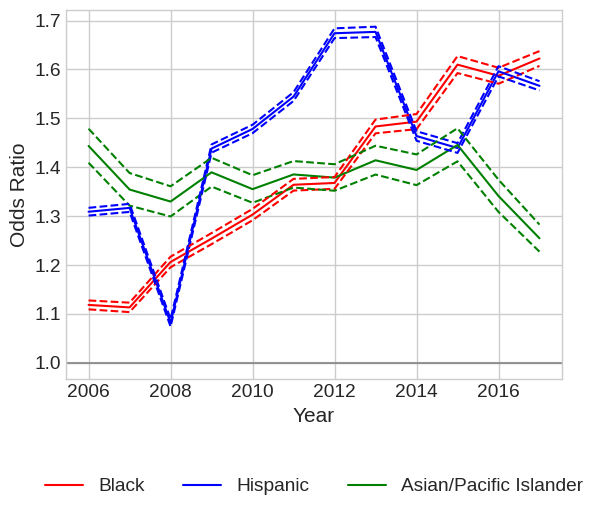

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=None, county_type=None, speeding_only=False)

### 1. Warning and Citation Rate

The plot included in the email is using the outcome variable. There are records with both citation_issued = 1 and warning_issued = 1, but in the outcome variable, it is classified as citation(citation / warning+citation);  warning(only warning), and nan.

In the citation_issued variable, citation = 1 also means only citation or citation+warning.

In the warning_issued variable, warning = 1 means only warning or citation+warning

In [ ]:
year_start = 2006
year_end = 2017

years = list(range(year_start, year_end+1))
for year in years:
  filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print(df['outcome'].value_counts(dropna = False))
  print('# of citation issued: ', sum(df['citation_issued']))
  print('# of warning issued: ', sum(df['warning_issued']))
  print('# of both citation and warning: ', len(df.loc[(df['citation_issued']==1) & (df['warning_issued']==1),:]))
  print('Check equation: ', len(df.loc[(df['citation_issued']==1) & (df['warning_issued']==1),:]) + df['outcome'].value_counts(dropna = False)['warning'] == sum(df['warning_issued']))

warning     1486673
citation    1207142
NaN              79
summons           0
arrest            0
Name: outcome, dtype: int64
# of citation issued:  1207142
# of warning issued:  1895614
# of both citation and warning:  408941
Check equation:  True
warning     1355355
citation    1071775
NaN             217
summons           0
arrest            0
Name: outcome, dtype: int64
# of citation issued:  1071775
# of warning issued:  1717430
# of both citation and warning:  362075
Check equation:  True
warning     1552946
citation     973574
NaN             263
summons           0
arrest            0
Name: outcome, dtype: int64
# of citation issued:  973574
# of warning issued:  1900742
# of both citation and warning:  347796
Check equation:  True
warning     1545015
citation     896255
NaN              36
summons           0
arrest            0
Name: outcome, dtype: int64
# of citation issued:  896255
# of warning issued:  1873889
# of both citation and warning:  328874
Check equation:  Tru

### 2. Separate Models for Border Counties and Non-border Counties

See definition at: https://www.dshs.texas.gov/regional-local-health-operations/texas-border-health/map-dshs-border-area


In [ ]:
county_df = pd.read_csv('/content/drive/MyDrive/traffic_stop/2014-2018.csv')
county_df = county_df[county_df['State']=='Texas']
county_df

,geoid,County Name,State,metro code,Metropolitan Status,Total Population,"Total population, MOE",Disabiltiy Population,"Disability Population, MOE",Disabitiy Rate,...,Disability Rate-Asian,Disability Rate-American Indian/Alaskan Native,Disability Rate-Native Hawaiian Pacific Islander,Disability Rate-Other race,Disability Rate-Two or more races,Disability Rate- Hispanic (of any race),Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35
2601,0500000US48001,Anderson,Texas,NaN,Micropolitan,44367,513,5500,453,12.4,...,0.0,16.9,0.0,2.7,22.2,4.8,NaN,NaN,NaN,NaN
2602,0500000US48003,Andrews,Texas,NaN,Micropolitan,17478,45,1662,246,9.5,...,0.0,0.0,0.0,2.0,22.6,6.8,NaN,NaN,NaN,NaN
2603,0500000US48005,Angelina,Texas,NaN,Micropolitan,85494,276,16037,782,18.8,...,9.5,5.4,0.0,11.6,16.7,8.7,NaN,NaN,NaN,NaN
2604,0500000US48007,Aransas,Texas,NaN,Metropolitan,24416,150,5075,565,20.8,...,21.0,79.8,NaN,9.9,27.6,13.9,NaN,NaN,NaN,NaN
2605,0500000US48009,Archer,Texas,NaN,Metropolitan,8725,59,1337,154,15.3,...,0.0,18.9,NaN,0.0,22.9,13.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,0500000US48499,Wood,Texas,NaN,Non core,42388,208,9248,604,21.8,...,32.4,25.9,0.0,4.0,12.5,11.7,NaN,NaN,NaN,NaN
2851,0500000US48501,Yoakum,Texas,NaN,Non core,8481,19,902,174,10.6,...,0.0,0.0,NaN,14.9,0.0,8.1,NaN,NaN,NaN,NaN
2852,0500000US48503,Young,Texas,NaN,Non core,17861,78,2656,367,14.9,...,46.7,12.6,NaN,4.9,0.0,3.7,NaN,NaN,NaN,NaN
2853,0500000US48505,Zapata,Texas,NaN,Micropolitan,14378,57,2467,367,17.2,...,0.0,NaN,NaN,30.4,NaN,16.4,NaN,NaN,NaN,NaN


In [ ]:
border_counties = ['Brewster', 'La Salle',
'Brooks',	'Maverick',
'Cameron',	'McMullen',
'Crockett',	'Pecos',
'Culberson',	'Presidio',
'Dimmit',	'Real',
'Duval',	'Reeves',
'Edwards',	'Starr',
'El Paso',	'Sutton',
'Frio',	'Terrell',
'Hidalgo',	'Uvalde',
'Hudspeth',	'Val Verde',
'Jeff Davis',	'Webb',
'Jim Hogg',	'Willacy',
'Kenedy',	'Zapata',
'Kinney',	'Zavala']

intersection = 0
unfound = 0
for county in border_counties:
  if county in list(county_df['County Name']):
    intersection += 1
  else:
    unfound += 1
    print(county)

print('intersection: ', intersection)
print('unfound: ', unfound)

intersection:  32
unfound:  0


#### Border Counties

##### All stops, citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  382756
# of traffic stops after preprocessing in year  2006 :  382597
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.684419
         Iterations 4
***********************************
2007
# of all tr

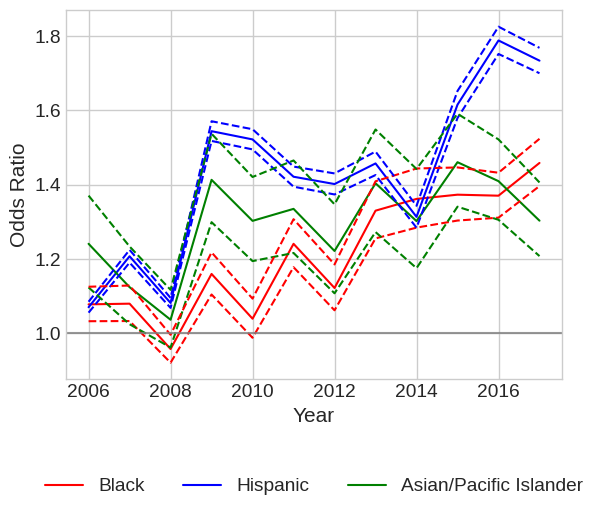

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=False)

##### All stops, search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  382756
# of traffic stops after preprocessing in year  2006 :  382597
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.139009
         Iterations 8
***********************************
2007
# of all tr

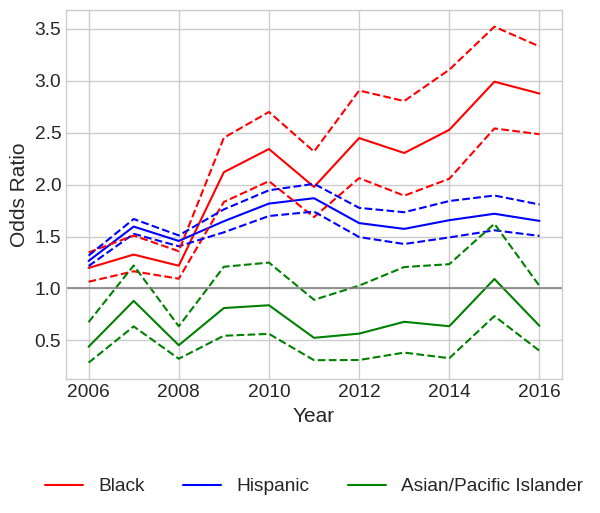

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=False)

##### All stops, contraband_found

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  382756
# of traffic stops after preprocessing in year  2006 :  12181
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.380286
         Iterations 6
***********************************
2007
# of all tra

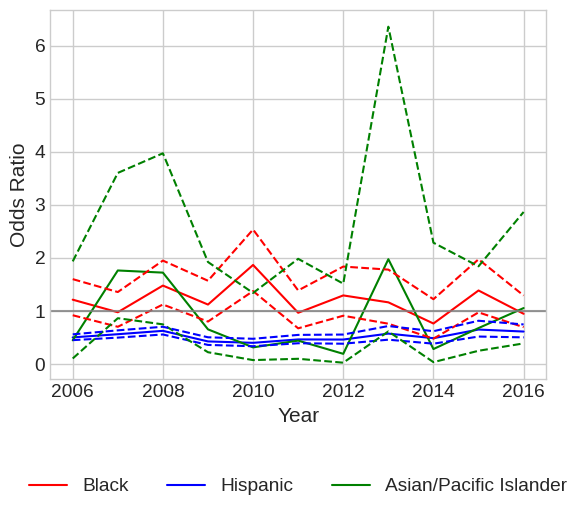

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=False)

##### speeding_only, citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  167628
# of traffic stops after preprocessing in year  2006 :  167541
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.67

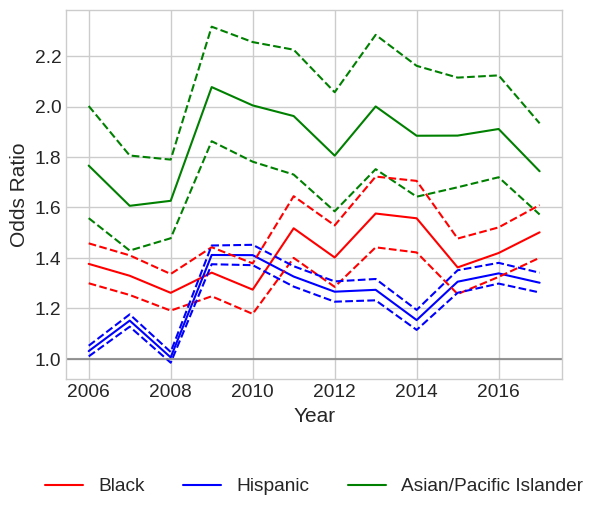

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=True)

##### speeding_only, search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  167628
# of traffic stops after preprocessing in year  2006 :  167541
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.05

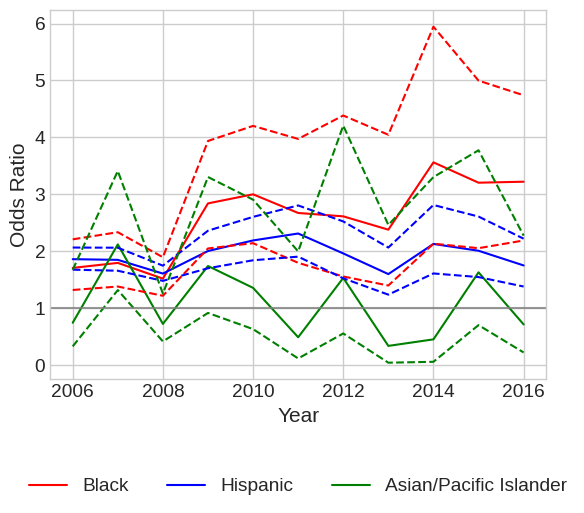

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=True)

##### speeding_only, contraband_found

(TOO FEW RECORDS, DID NOT CONVERGE)

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=border_counties, county_type=None, speeding_only=True)

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  167628
# of traffic stops after preprocessing in year  2006 :  1793
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
         Current function value: 0.155212
         Iterations: 35
***********

LinAlgError: ignored

#### Non-border Counties

(Manually change the file name line in the generate_output_function)

###### All stops, citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  2290755
# of traffic stops after preprocessing in year  2006 :  2289111
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.682552
         Iterations 4
***********************************
2007
# of all 

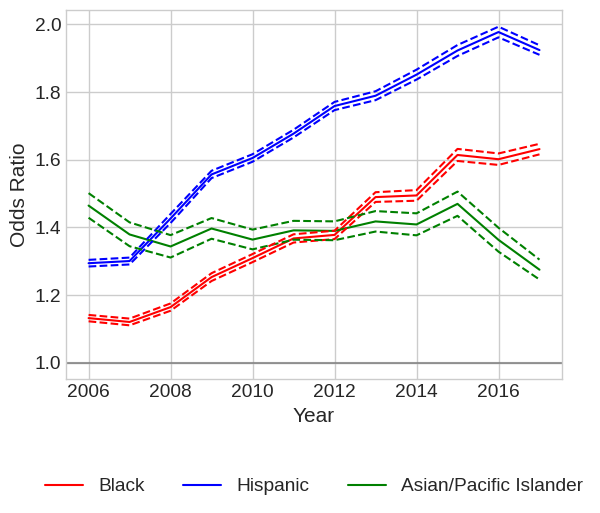

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=False)

##### all stops, search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  2290755
# of traffic stops after preprocessing in year  2006 :  2289111
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.136955
         Iterations 8
***********************************
2007
# of all 

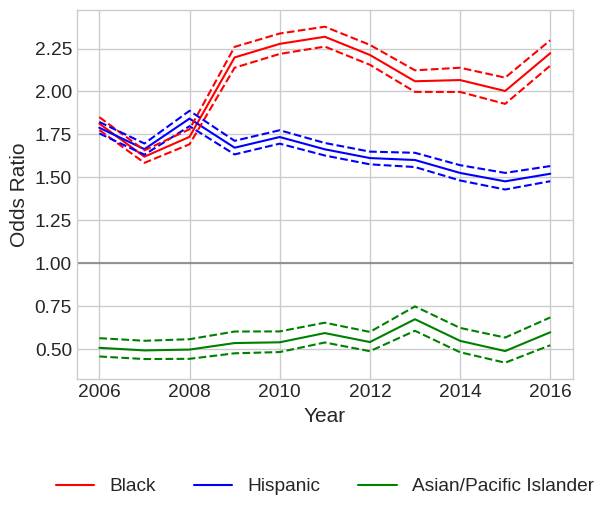

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=False)

##### all stops, contraband_found

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  2290755
# of traffic stops after preprocessing in year  2006 :  72221
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.600508
         Iterations 6
***********************************
2007
# of all tr

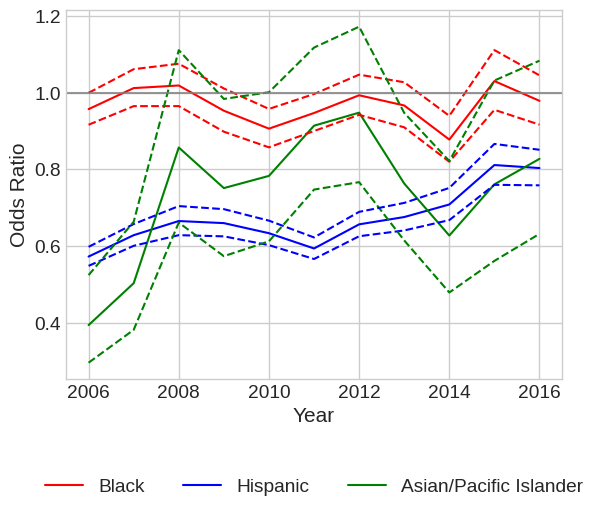

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=False)

##### speeding-only, citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  1067475
# of traffic stops after preprocessing in year  2006 :  1066587
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.

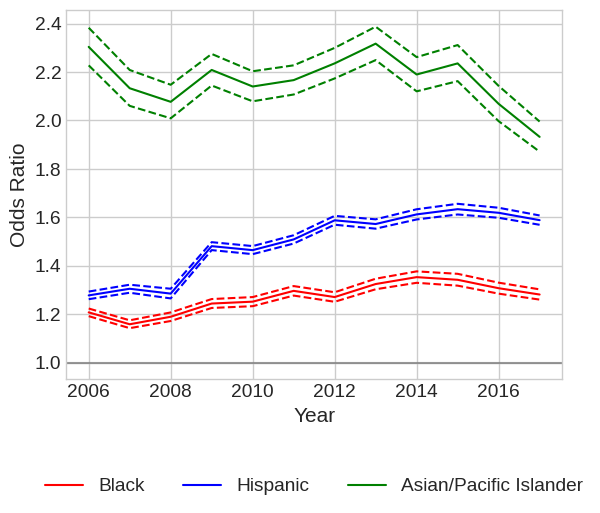

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=True)

##### speeding-only, search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  1067475
# of traffic stops after preprocessing in year  2006 :  1066587
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.

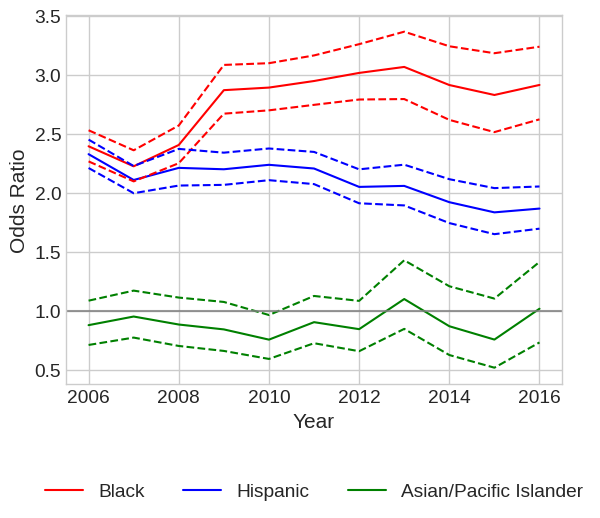

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=True)

##### speeding-only, contraband_found

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only border counties
# of traffic stops after preprocessing step 1(add county type):  1067475
# of traffic stops after preprocessing in year  2006 :  9288
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.259

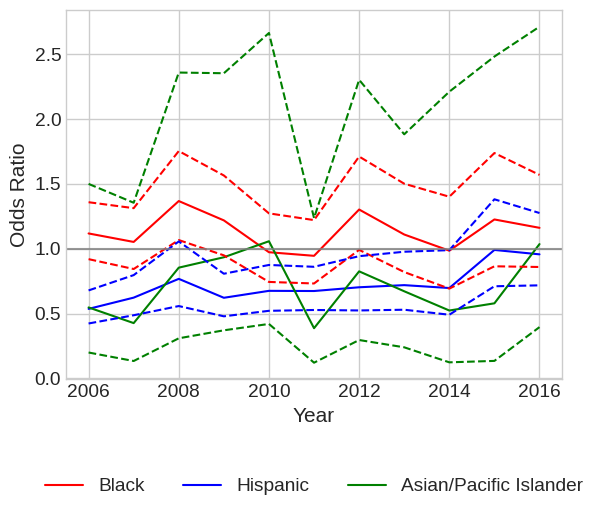

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=non_border_counties, county_type=None, speeding_only=True)

### 3. Model for Most Serious Speeding Offences

In [ ]:
all_dict = {}
cite_dict = {}

for year in list(range(2006, 2018)):
  print(year)
  df = pd.read_parquet(('/content/drive/MyDrive/traffic_stop/year_data_speeding_only/traffic_'+str(year)+'.parquet'), engine = 'pyarrow')
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1', 'speeding_multiple'])]
  vio_lst = list(df['violation'].unique())

  for vio in vio_lst:
    df_temp = df.loc[df['violation'] == vio,:]
    if vio in list(all_dict.keys()):
      all_dict[vio] += len(df_temp)
      cite_dict[vio] += sum(df_temp['citation_issued'])
    else:
      all_dict[vio] = len(df_temp)
      cite_dict[vio] = sum(df_temp['citation_issued'])

vio_name = []
type_count = []
citation_prop = []

for vio in list(all_dict.keys()):
  vio_name.append(vio)
  type_count.append(all_dict[vio])
  citation_prop.append((cite_dict[vio]/all_dict[vio]))

citation_prop = ['{:.4f}'.format(x) for x in citation_prop]
ticket_df = pd.DataFrame({'violation': vio_name, 'count':type_count,'citation_prop': citation_prop})
ticket_df = ticket_df.sort_values(by = 'citation_prop', ascending=False)

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [ ]:
ticket_df

,violation,count,citation_prop
17,speeding-15 mph and over posted speed limit-cm...,1,1.0000
3,fail to control speed,88664,0.9834
2,unsafe speed,79500,0.9804
1,speeding-10% or more above posted speed,3510924,0.9764
7,speeding cmv 15 mph or more over limit,3008,0.9219
12,fail to stop/reduce speed or shifted gears at ...,3,0.6667
13,vehicle hauling explosives or flammable materi...,5,0.6000
5,speeding-school zone,19489,0.5347
10,speeding (over 35 mph) motor driven cycle (eff...,185,0.4703
4,"speeding - zoned (inclement weather, signs pos...",16714,0.2110


In [ ]:
serious_speeding_violations = ['fail to control speed','unsafe speed','speeding-10% or more above posted speed','speeding cmv 15 mph or more over limit']

##### citation

***********************************
2006
# of all traffic stops in year  2006 :  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  1234128
Including only serious violations
466848
# of traffic stops after preprocessing step 1(add county type):  466848
# of traffic stops after preprocessing in year  2006 :  466848
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.032324
         Iterations 10
***********************************
2007


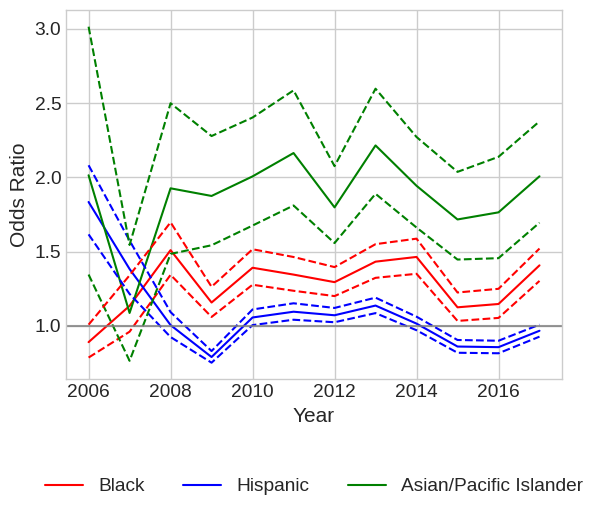

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=serious_speeding_violations, border_counties=None, county_type=None, speeding_only=False)

##### search

***********************************
2006
# of all traffic stops in year  2006 :  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  1234128
Including only serious violations
466848
# of traffic stops after preprocessing step 1(add county type):  466848
# of traffic stops after preprocessing in year  2006 :  466848
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.069441
         Iterations 9
***********************************
2007
#

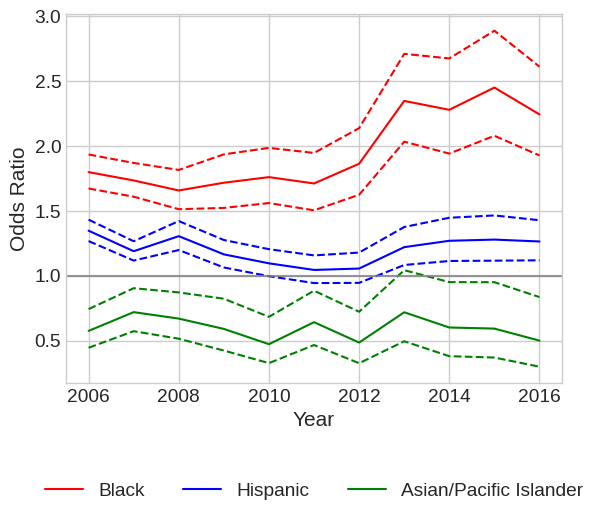

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=serious_speeding_violations, border_counties=None, county_type=None, speeding_only=False)

##### contraband

***********************************
2006
# of all traffic stops in year  2006 :  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  1234128
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  1234128
Including only serious violations
466848
# of traffic stops after preprocessing step 1(add county type):  466848
# of traffic stops after preprocessing in year  2006 :  6189
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.271215
         Iterations 8
***********************************
2007
# o

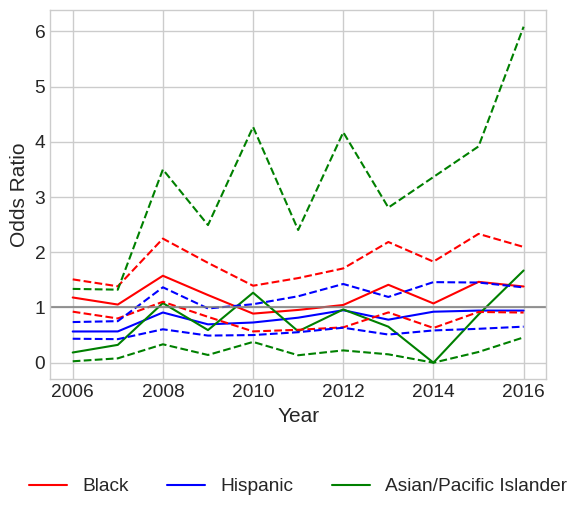

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
non_border_counties = [county for county in list(county_df['County Name']) if county not in border_counties]
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=serious_speeding_violations, border_counties=None, county_type=None, speeding_only=False)

### 4. Descriptive Stats of the Demographics from the Stops Data

In [ ]:
males = []
females = []

white = []
hispanic = []
black = []
asian = []

total_records = []

for year in years:
  filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  males.append(df['subject_sex'].value_counts(dropna = False)['male']/len(df))
  females.append(df['subject_sex'].value_counts(dropna = False)['female']/len(df))
  #unknown_gender.append(int(df['subject_sex'].isna().sum())/len(df))

  white.append(df['subject_race'].value_counts(dropna = False)['white']/len(df))
  hispanic.append(df['subject_race'].value_counts(dropna = False)['hispanic']/len(df))
  black.append(df['subject_race'].value_counts(dropna = False)['black']/len(df))
  asian.append(df['subject_race'].value_counts(dropna = False)['asian/pacific islander']/len(df))
  #unknown_race.append(int(df['subject_race'].isna().sum())/len(df))

  total_records.append(len(df))

result_df = pd.DataFrame({'years':years, 'female':females, 'male':males, 'white':white, 'hispanic':hispanic, 'black':black, 'asian':asian})

result_df_gender = result_df[['years','female','male']]
result_df_gender['unknown'] = 1-result_df_gender['female']-result_df_gender['male']
result_df_race = result_df[['years','white','hispanic','black', 'asian']]
result_df_race['unknown'] = 1-result_df_race['white']--result_df_race['hispanic']--result_df_race['black']--result_df_race['asian']


In [ ]:
result_df_gender

,years,female,male,unknown
0,2006,0.303428,0.696572,0.000000
1,2007,0.299796,0.700204,0.000000
2,2008,0.295731,0.704269,0.000000
3,2009,0.311744,0.688256,0.000000
4,2010,0.317156,0.682844,0.000000
5,2011,0.321596,0.678400,0.000003
6,2012,0.323267,0.676711,0.000022
7,2013,0.327030,0.672882,0.000089
8,2014,0.325900,0.674088,0.000012
9,2015,0.330434,0.669552,0.000014


<Axes: title={'center': 'Stacked Bar Graph'}, ylabel='years'>

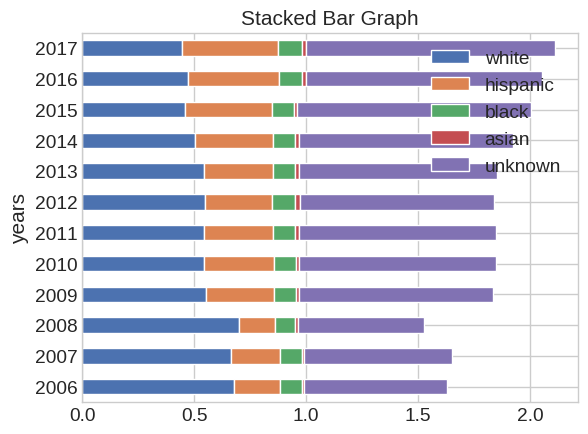

In [ ]:
result_df_race.plot(
    x = 'years',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)

<Axes: title={'center': 'Stacked Bar Graph'}, ylabel='years'>

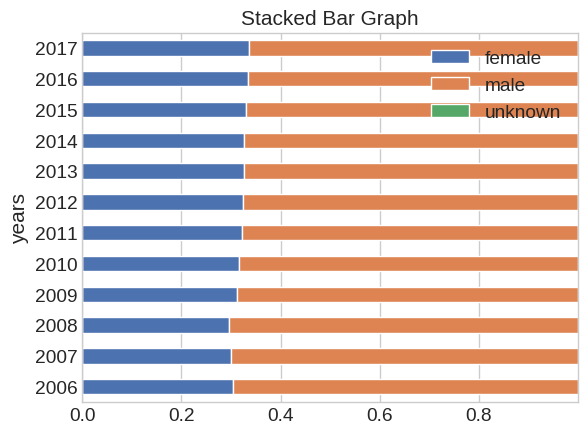

In [ ]:
result_df_gender.plot(
    x = 'years',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)

### 5. (speeding-only) Separate Logistic Regression Models and Odds Ratio Plots for Metropolitan, Micropolitan, and Non-core

##### speeding-only, metro

###### citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  637232
# of traffic stops after preprocessing in year  2006 :  636818
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.674121
         Iterations 4
***********************

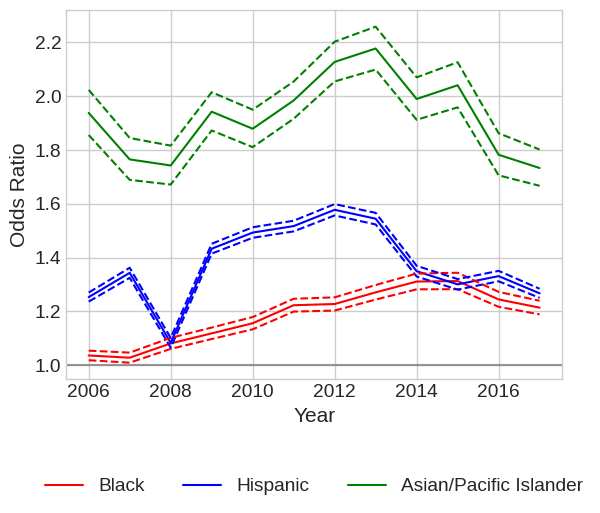

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=None, county_type='Metropolitan', speeding_only=True)

###### search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  637232
# of traffic stops after preprocessing in year  2006 :  636818
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.048278
         Iterations 9
***********************

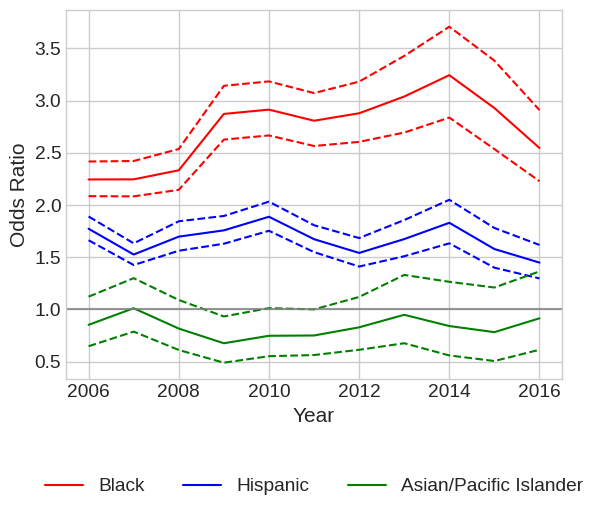

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=None, county_type='Metropolitan', speeding_only=True)

###### contraband

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  637232
# of traffic stops after preprocessing in year  2006 :  5462
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.249847
         Iterations 7
*************************

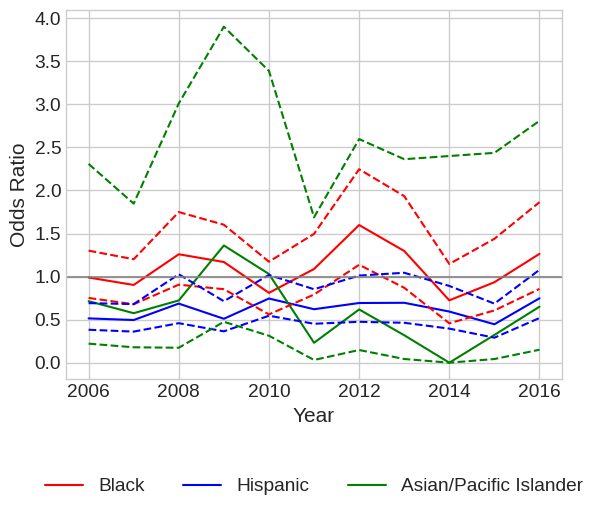

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=None, county_type='Metropolitan', speeding_only=True)

##### speeding-only, micro

###### citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  226486
# of traffic stops after preprocessing in year  2006 :  226270
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.625337
         Iterations 5
***********************

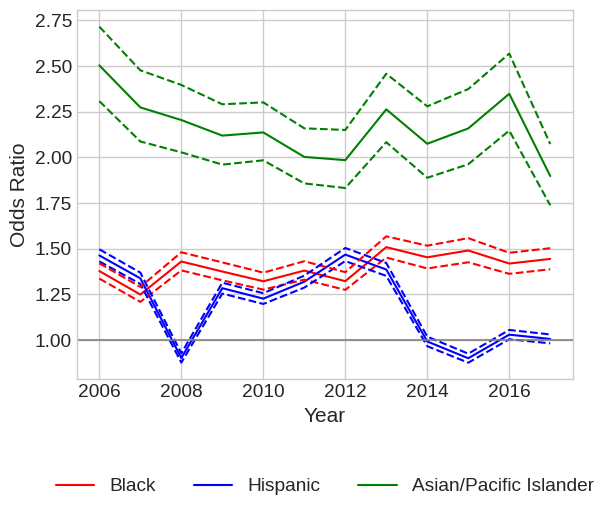

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=None, county_type='Micropolitan', speeding_only=True)

###### search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  226486
# of traffic stops after preprocessing in year  2006 :  226270
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.053905
         Iterations 9
***********************

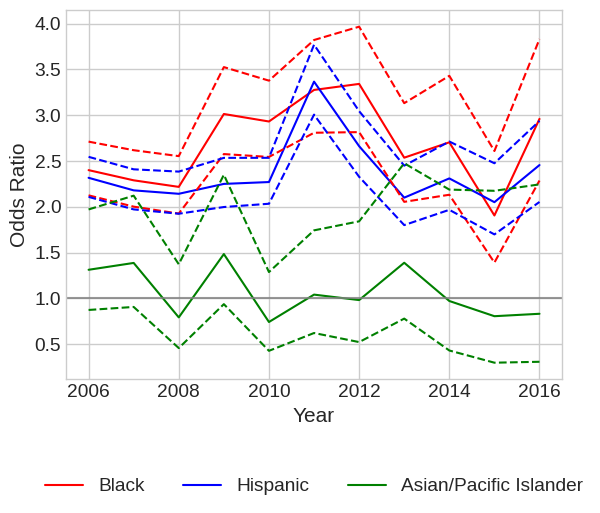

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=None, county_type='Micropolitan', speeding_only=True)

###### contraband

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  226486
# of traffic stops after preprocessing in year  2006 :  2236
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.227794
         Iterations 7
*************************

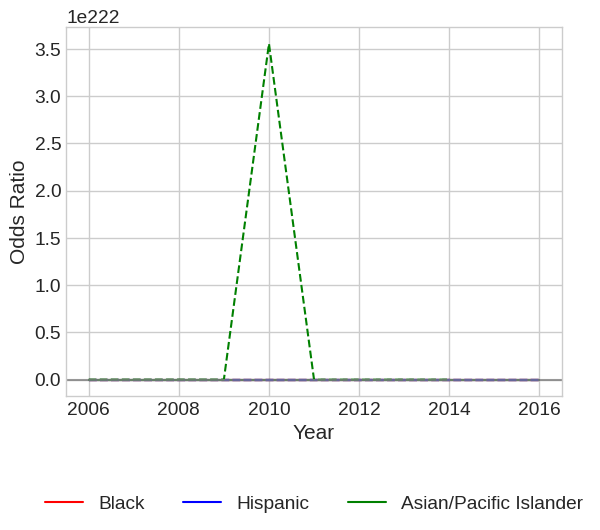

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=None, county_type='Micropolitan', speeding_only=True)

##### speeding-only, non-core

###### citation

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  371385
# of traffic stops after preprocessing in year  2006 :  371040
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.652559
         Iterations 4
***********************

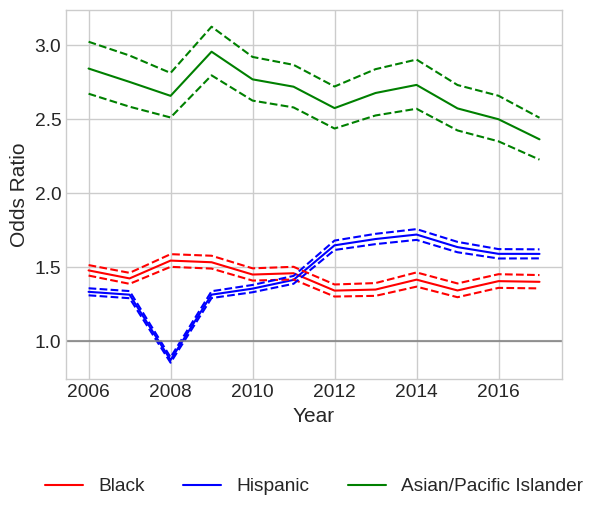

In [ ]:
year_start = 2006
year_end = 2017

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=None, county_type='Non core', speeding_only=True)

###### search

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  371385
# of traffic stops after preprocessing in year  2006 :  371040
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.050288
         Iterations 10
**********************

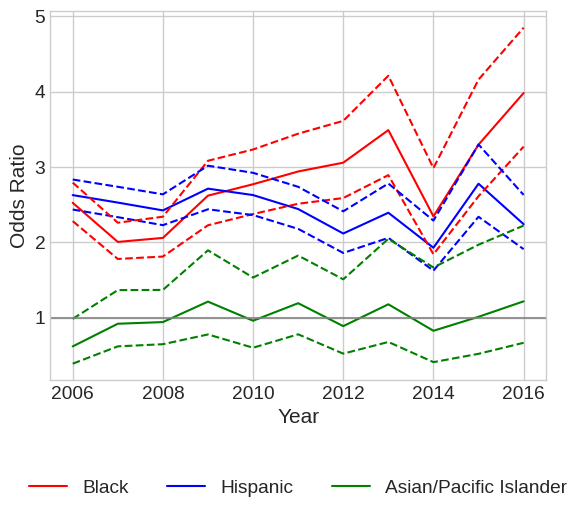

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=None, county_type='Non core', speeding_only=True)

###### contraband

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
Including only a certain type of county
# of traffic stops after preprocessing step 1(add county type):  371385
# of traffic stops after preprocessing in year  2006 :  3383
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female'],
      dtype='object')
         Current function value: 0.243371
         Iterations: 35
***********************************
2007
# of all traffic sto

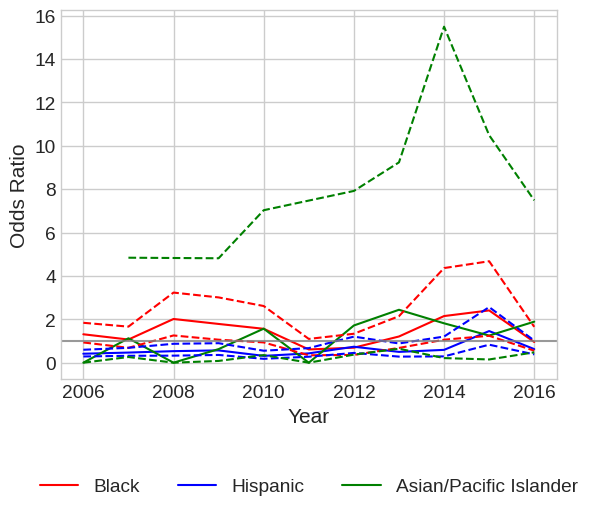

In [ ]:
year_start = 2006
year_end = 2016

asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []

folder_path ='/content/drive/MyDrive/traffic_stop/FINAL_OUTPUTS/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=None, county_type='Non core', speeding_only=True)

### 6. COLLECT INFO: Demographics Stats of *all* drivers (find this info from some government/ACS website)

demographic info of all drivers: https://www.zippia.com/driver-jobs/demographics/


race and gender

In [3]:
filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(2006) + '.parquet'
df = pd.read_parquet(filename, engine = 'pyarrow')
df_demo = pd.DataFrame(columns = ['year', 'male', 'female', 'white', 'hispanic', 'black', 'asian'])

for year in list(range(2007, 2018)):
  print(year)
  df = pd.read_parquet(('/content/drive/MyDrive/traffic_stop/year_data/traffic_'+str(year)+'.parquet'), engine = 'pyarrow')
  df_gender = df['subject_sex'].value_counts()
  df_race = df['subject_race'].value_counts()
  # exclude unknown/other races from the analysis
  df_demo.loc[len(df.index)] = [year, int(df_gender.loc['male']), int(df_gender.loc['female']),
                                int(df_race.loc['white']), int(df_race.loc['hispanic']), int(df_race.loc['black']), int(df_race.loc['asian/pacific islander'])]
df_demo

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


,year,male,female,white,hispanic,black,asian
2427347,2007,1699637,727710,1610647,529916,237865,25894
2526783,2008,1779536,747247,1765640,413522,223244,29668
2441306,2009,1680243,761063,1347251,748485,236026,36461
2525296,2010,1724383,800913,1377987,780653,251410,39327
2588004,2011,1755702,832293,1407655,793816,262052,44695
2435812,2012,1648341,787418,1340746,726378,253645,43894
2134936,2013,1436559,698188,1159206,658188,215565,38511
1878488,2014,1266266,612199,946045,655358,181853,32904
1745385,2015,1168626,576735,801762,676307,169820,30725
1832207,2016,1220756,611338,863280,751113,188002,28232


In [4]:
df_demo['male_percentage'] = df_demo.apply(lambda x: x['male']/(x['male']+x['female']), axis = 1)
df_demo['female_percentage'] = df_demo.apply(lambda x: x['female']/(x['male']+x['female']), axis = 1)
df_demo['white_percentage'] = df_demo.apply(lambda x: x['white']/(x['white']+x['hispanic']+x['black']+x['asian']), axis = 1)
df_demo['black_percentage'] = df_demo.apply(lambda x: x['black']/(x['white']+x['hispanic']+x['black']+x['asian']), axis = 1)
df_demo['hispanic_percentage'] = df_demo.apply(lambda x: x['hispanic']/(x['white']+x['hispanic']+x['black']+x['asian']), axis = 1)
df_demo['asian_percentage'] = df_demo.apply(lambda x: x['asian']/(x['white']+x['hispanic']+x['black']+x['asian']), axis = 1)

In [5]:
df_demo

,year,male,female,white,hispanic,black,asian,male_percentage,female_percentage,white_percentage,black_percentage,hispanic_percentage,asian_percentage
2427347,2007,1699637,727710,1610647,529916,237865,25894,0.700204,0.299796,0.669897,0.098932,0.220401,0.010770
2526783,2008,1779536,747247,1765640,413522,223244,29668,0.704269,0.295731,0.725981,0.091792,0.170029,0.012199
2441306,2009,1680243,761063,1347251,748485,236026,36461,0.688256,0.311744,0.568887,0.099664,0.316053,0.015396
2525296,2010,1724383,800913,1377987,780653,251410,39327,0.682844,0.317156,0.562587,0.102642,0.318715,0.016056
2588004,2011,1755702,832293,1407655,793816,262052,44695,0.678402,0.321598,0.561217,0.104477,0.316486,0.017819
2435812,2012,1648341,787418,1340746,726378,253645,43894,0.676726,0.323274,0.566992,0.107265,0.307180,0.018562
2134936,2013,1436559,698188,1159206,658188,215565,38511,0.672941,0.327059,0.559605,0.104064,0.317740,0.018591
1878488,2014,1266266,612199,946045,655358,181853,32904,0.674096,0.325904,0.520904,0.100130,0.360848,0.018117
1745385,2015,1168626,576735,801762,676307,169820,30725,0.669561,0.330439,0.477633,0.101167,0.402896,0.018304
1832207,2016,1220756,611338,863280,751113,188002,28232,0.666317,0.333683,0.471576,0.102698,0.410304,0.015422


Text(0.5, 1.0, 'Traffic Stop Gender Composition')

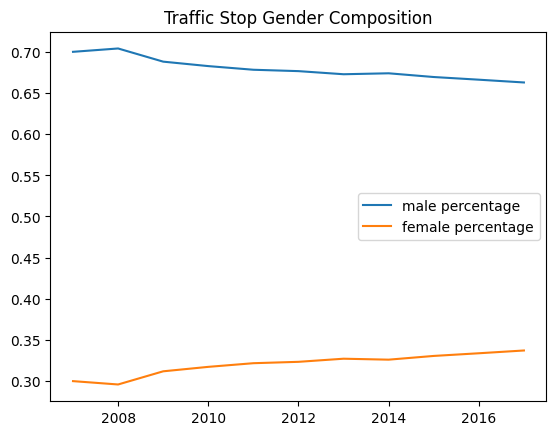

In [7]:
plt.plot(df_demo['year'],df_demo['male_percentage'], label = 'male percentage')
plt.plot(df_demo['year'],df_demo['female_percentage'], label = 'female percentage')
plt.legend()
plt.title('Traffic Stop Gender Composition')

Text(0.5, 1.0, 'Traffic Stop Race Composition')

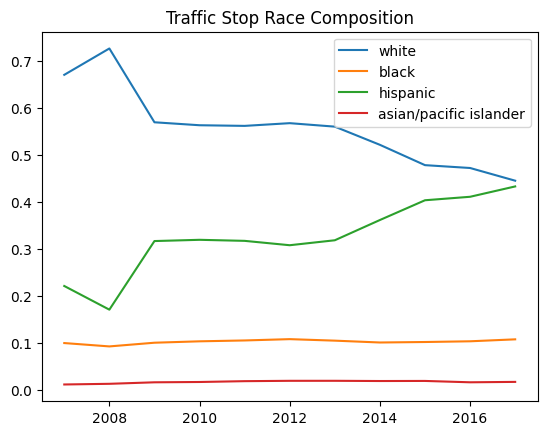

In [8]:
plt.plot(df_demo['year'],df_demo['white_percentage'], label = 'white')
plt.plot(df_demo['year'],df_demo['black_percentage'], label = 'black')
plt.plot(df_demo['year'],df_demo['hispanic_percentage'], label = 'hispanic')
plt.plot(df_demo['year'],df_demo['asian_percentage'], label = 'asian/pacific islander')
plt.legend()
plt.title('Traffic Stop Race Composition')

Text(0.5, 1.0, 'Traffic Stop Gender Composition')

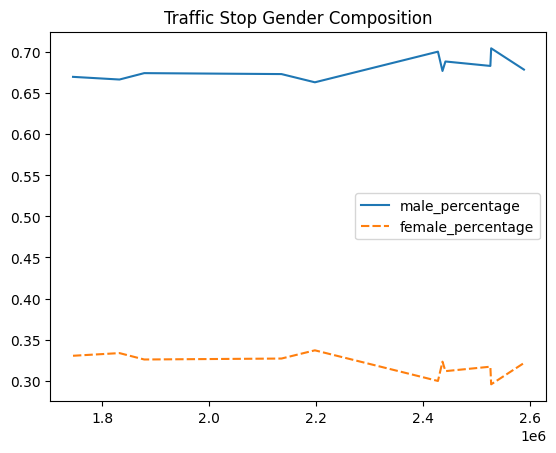

In [30]:
sns.lineplot(data = df_demo[['male_percentage','female_percentage']])
plt.title('Traffic Stop Gender Composition')

Text(0.5, 1.0, 'Race Composition')

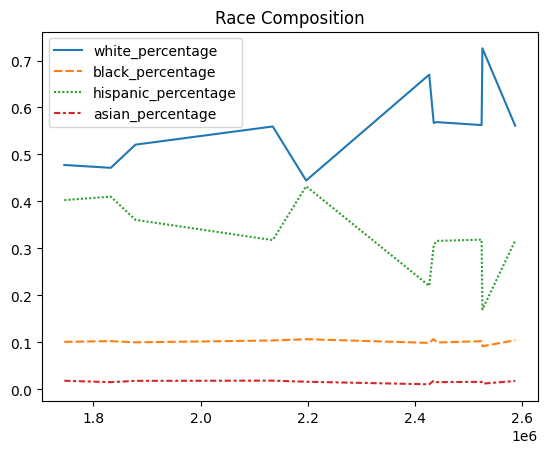

In [31]:
sns.lineplot(data = df_demo[['white_percentage','black_percentage','hispanic_percentage','asian_percentage']])
plt.title('Race Composition')

### 7. COLLECT INFO: Create countyinfo.csv and push it to repository

### 8. What is that 'perfect separation' when using search as y?